## Fazendo os imports

In [26]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import plotly.graph_objects as go

# Imports ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf     

# Imports Prophet
from prophet import Prophet

## Extração da base de dados

##### A função extrai de forma incremental, para garantir a atualização correta dos dados

In [27]:
#Variáveis Globais
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

In [28]:
#Função para extrair os dados de forma incremental do site IPEA
def extrai_dados_ipea_incremental(url):
    
    resposta = requests.get(url)

    if resposta.status_code == 200:

        soup = BeautifulSoup(resposta.text, 'html.parser')
        table = soup.find('table', {'id': 'grd_DXMainTable'})

        df_new_data = pd.read_html(str(table), header=0)[0]
        df_new_data.columns = ['data', 'preco_petroleo' ]
        df_new_data['data'] = pd.to_datetime(df_new_data['data'], dayfirst=True)
        df_new_data['preco_petroleo'] = df_new_data['preco_petroleo']/100

        path = 'dados\ipea.csv'

        try:
            df_existente = pd.read_csv(path)
            print(df_existente)
            df_existente['data'] = pd.to_datetime(df_existente['data'], format="%Y-%m-%d")
            

        except FileNotFoundError:
            df_existente = df_new_data
        

        
        #Caso já tenha um arquivo salvo, entende de quando deverá puxar os novos dados
        last_date = df_existente['data'].max()
        new_rows = df_new_data[df_new_data['data'] > last_date]

        if new_rows.empty:
            updated_df = df_existente
        else:
            updated_df = pd.concat([df_existente, new_rows], ignore_index=True)
            
        #Gera o arquivo atualizado
        updated_df.to_csv(path, index=False)
        updated_df.head()

        return updated_df

    else:
        print("Falha ao acessar a página: Status Code", resposta.status_code)


<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Bruna\AppData\Local\Temp\ipykernel_24384\2763138798.py:16: SyntaxWarning: invalid escape sequence '\i'
  path = 'dados\ipea.csv'


In [29]:
updated_df = extrai_dados_ipea_incremental(url)

C:\Users\Bruna\AppData\Local\Temp\ipykernel_24384\2763138798.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_new_data = pd.read_html(str(table), header=0)[0]


             data  preco_petroleo
0      2024-05-03           83.60
1      2024-05-02           84.81
2      2024-05-01           83.55
3      2024-04-30           88.23
4      2024-04-29           88.44
...           ...             ...
11164  2024-05-13           83.18
11165  2024-05-10           83.39
11166  2024-05-09           83.27
11167  2024-05-08           82.44
11168  2024-05-07           82.69

[11169 rows x 2 columns]


## Overview da série temporal e estudo de milestones

In [30]:
#Criando uma cópia do dataframe para não alterarmos os dados originais
df_eda = updated_df

In [31]:
df_eda.head()

,data,preco_petroleo
0,2024-05-03,83.60
1,2024-05-02,84.81
2,2024-05-01,83.55
3,2024-04-30,88.23
4,2024-04-29,88.44


In [32]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data            11169 non-null  datetime64[ns]
 1   preco_petroleo  11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


In [33]:
df_eda.head()

,data,preco_petroleo
0,2024-05-03,83.60
1,2024-05-02,84.81
2,2024-05-01,83.55
3,2024-04-30,88.23
4,2024-04-29,88.44


In [34]:
#Ordendo através do indice que já está em datetime
df_eda.sort_values(by='data', ascending=True, inplace=True)

#### Visualizando a série temporal

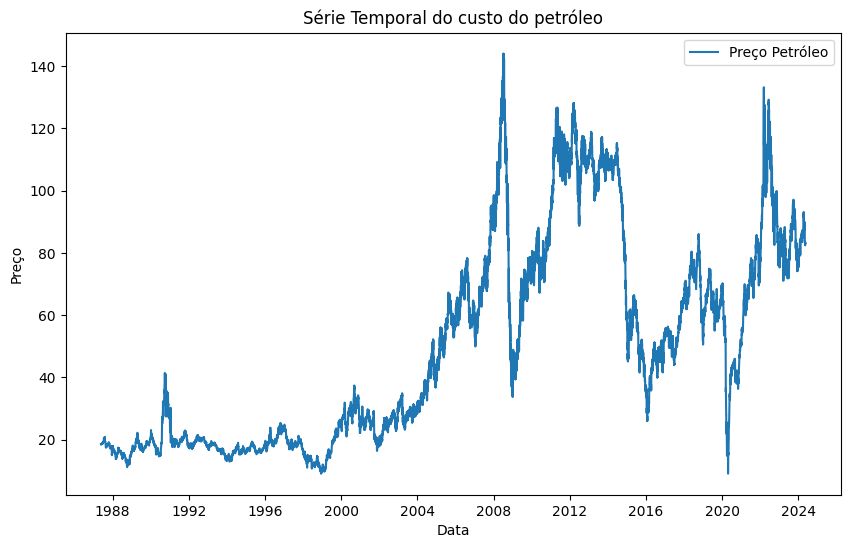

In [35]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df_eda['data'], df_eda['preco_petroleo'], label = 'Preço Petróleo')
plt.title('Série Temporal do custo do petróleo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend(loc='best')
plt.show()

Milestones:

 **1. Pico em 2008:** O preço do petróleo apresentava um aumento contnuo desde 2002. Do fim de 2007 até a metade de 2008, a proporção desse aumento de preço aumentou substancialmente, chgeando a a ultrapassar a barreira de U$140. O aumento escalar da época foi causado por um conjunto de fatores:

    I) Especulação;

    II) Tensões geopolíticas;

    III) Relação entre demanda/oferta. Demanda puxada pelos países emergentes (China e Índia, especialmente.);

    IV) O fato de ser um combustível fóssil não renovável;

    V) Mercado financeiro passava por uma tendência de investimento em matérias primas. 

 **2. Queda abrupta em 2009:** A famosa crise financeira global de 2009 foi a principal responsável pela queda abrupta nos preços dos barris de petróleo. Como os países estavam em recessão, a demanda por petróleo consequentemente diminuiu no período levando junto o seu preço.

 **3. Nova queda abrupta em 2014:** Causada principalmente pelo aumento da oferta, especulação do mercado, fatores políticos e ambientais.

    I) Aumento da oferta: 

        - O EUA investiu em tecnologias inovadoras e aumentou em 40% a sua produção, tornando-se o maior produtor mundial. Os 40% representavam 4milhões de barris de ptróleo por dia, que equivaliam à produção conjunta da Nigéria, Angola e Líbia, alguns dos maiores produtores no país africano. Além disso, isso fez com que os EUA dependessem minimamente da importação do combustível, passando também a exportar (Ou seja, aumentando a oferta).

        - O Iraque foi o segundo país com maior aumento de produção no período, cerca de 1milhão de barris a mais por dia.

        - Entrada do Iran no acordo nuclear juntamente ao Grupo 5 +1 (Estados Unidos, Reino Unido, Rússia, China, França, mais Alemanha) possibilitou a volta do Irã ao mercado petroleiro. Na prática a produção aumentou em  cerca de mais 300mil barris por dia. 

        - O Brasil aumentou significativamente o volume de produção, tornando-se líder na exploração offshore em águas ultraprofundas. Grandes descobertas dde petróleo no pré-sal foram descobertas e aumentaram a produção em 400mil barris por dia.

        - A Arábia Saudita devido à suas vastas reservas de petróleo é capaz de influenciar o mercado estrategicamente. Optaram por produzir mais para segundo analistas, manterem a quota do mercado. Com preços mais baixos e os investimentos em fracking (EUA) e águas ultraprofundas (Brasil) deixam de ser rentáveis. O que ao longo prazo pode tornar a Arábia Saudita a protagonista da exportação.

    II) Especulação do mercado:

        - Muitos analistas e investidores temiam que, por trás dos números oficiais disponibilizados pelo país asiático se escondia uma realidade bem pior. A queda das ações nas bolsas chinesas foi um indício de que o milagre econômico chinês podia estar próximo ao fim. Isso causou nervosismo nos mercados pois a China foi um dos principais players que fomentaram o boom na importação dos recursos naturais dos países emergentes, aumentando nos últimos dez anos o seu consumo em mais de 4 milhões de barris por dia, o que representa uma parcela substancial do mercado e com a influencia necessária de impactar o preço do barril.

    III) Fatores ambientais: O ano de 2015 foi um dos mais quente desde que começaram os registros de temperatura no século 19 e o fenômeno meteorológico "El Niño" poderia piorar a situação em 2016. Isso reduziu uma parcela significativa pela busca por gasóleo para aquecimento nos EUA, Europa e Japão. (Ou seja, diminuindo a demanda)

    IV) Fatores políticos: Apesar dos 13 países-membros da OPEP representarem um terço da produção global de barris de petróleo, nenhum deles cortaram a produção no período. 


 **4. Nova queda abrupta em 2020:** Impulsinada pelo avanço da pandemia do Covid-19, outro agravante que levou a esse cenário foi o corte nos preços do barril de petróleo pela Arábia Saudita. Isso aconteceu após a ruptura de aliança entre Rússia e a OPEP.

    I) A epidemia de Covid-19 na China se transformou em uma pandemia global. Isso causou uma recessão na economia de vários países e por consequência a redução na demanda pelo combustível. 

    II) Desde 2016 a OPEP já tinha criado uma estratégia de redução na produção (oferta) de barris de petróleo com o objetivo de recuperar os preços dos barris. Isso funcionou até 2020, quando a Rússia se opos a uma nova proposta de redução. Isso iniciou uma "Guerra de Preços" entre os dois países, com a Arábia Saudita praticando descontos de até U$8, potencializando a queda no valor do commodity drasticamente. 

**5. Novo pico em 2022:** O fim das restrições para o combate à Covid-19 juntamente ao avanço das campanhas de vacinação mundiais melhorou a expectativa pela recuperação da economia mundial, aumentando a confiança dos investidores nos mercados de commodities. A OPEP também coordenou novo corte de produção, diminuindo a oferta do combustível no mercado e por consequência alterando a balança comercial. 





## Análise exploratória dos dados.

### Decompondo a série temporal para entender ruídos, sazonalidades e tendências

In [36]:
# Preenchendo os dias faltantes (FDS + Feriados)
df_eda.set_index('data', inplace=True)
df_eda = df_eda.asfreq('D').fillna(method='ffill')

C:\Users\Bruna\AppData\Local\Temp\ipykernel_24384\1074005026.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


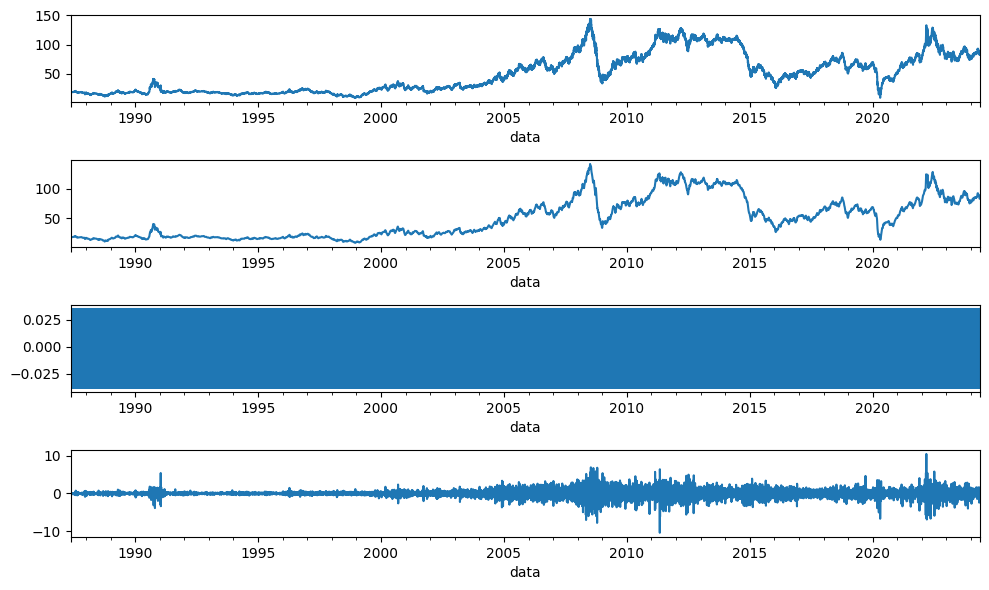

In [37]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

#### Analisando a decomposição da série temporal, podemos observar que:

- Tendência: A tendência geral ao longo do tempo indica um crescimento nos preços do petróleo. Apesar das flutuações e dos períodos de queda, a direção geral parece ser ascendente.

- Sazonalidade: Não há um padrão sazonal forte ou significativo, indicando que os preços do petróleo não seguem um ciclo repetitivo regular.

- Ruído: O ruído mostra a variabilidade aleatória e os eventos imprevisíveis que afetam os preços do petróleo.

### Verificando estacionariedade através do Teste de Dickey-Fuller Aumentado (ADF)

In [38]:
# Teste de ADF para verificar estacionariedade

adf_result = adfuller(df_eda['preco_petroleo'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.049434862459241
p-value: 0.2653267626278458
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.049434862459241
Valor-p: 0.2653267626278458
Valores Críticos:
   1%: -3.4308356721535813
   5%: -2.861754644287439
   10%: -2.566884250284692


#### Concluímos que a série temporal não é estacionária pois o valor de 'p' está muito alto e o valor do Teste Estatístico é muito maior do que os valores críticos.

## Construindo o modelo

#### O modelo escolhido será o Prophet, que não depende de estacionariedade para realizar previsões.

In [39]:
df_prophet = df_eda.reset_index().rename(columns={'data':'ds', 'preco_petroleo':'y'})
df_prophet.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-23,18.55
4,1987-05-24,18.55


In [40]:
# Dividindo a base entre treino e teste

split_point = int(len(df_prophet) * 0.90)
treino = df_prophet.iloc[:split_point]
valid = df_prophet.iloc[split_point:]
print(f'Treino : {treino.shape}')
print(f'Valid: {valid.shape}')

Treino : (12158, 2)
Valid: (1351, 2)


In [41]:
# Fazendo o treinamento do modelo

modelo = Prophet(daily_seasonality=True)
modelo.fit(treino)

dataFramefuture = modelo.make_future_dataframe(periods=90, freq='D')

previsao = modelo.predict(dataFramefuture)
previsao

17:16:13 - cmdstanpy - INFO - Chain [1] start processing
17:16:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,17.700956,0.930346,29.960796,17.700956,17.700956,-1.337447,-1.337447,-1.337447,-2.323808,...,-0.027910,-0.027910,-0.027910,1.014271,1.014271,1.014271,0.0,0.0,0.0,16.363509
1,1987-05-21,17.705640,0.562471,31.043638,17.705640,17.705640,-1.264235,-1.264235,-1.264235,-2.323808,...,0.025839,0.025839,0.025839,1.033734,1.033734,1.033734,0.0,0.0,0.0,16.441405
2,1987-05-22,17.710325,1.443051,30.734109,17.710325,17.710325,-1.267816,-1.267816,-1.267816,-2.323808,...,0.006264,0.006264,0.006264,1.049728,1.049728,1.049728,0.0,0.0,0.0,16.442509
3,1987-05-23,17.715010,1.967782,31.147691,17.715010,17.715010,-1.286354,-1.286354,-1.286354,-2.323808,...,-0.024612,-0.024612,-0.024612,1.062066,1.062066,1.062066,0.0,0.0,0.0,16.428656
4,1987-05-24,17.719695,2.141844,30.650930,17.719695,17.719695,-1.268953,-1.268953,-1.268953,-2.323808,...,-0.015773,-0.015773,-0.015773,1.070628,1.070628,1.070628,0.0,0.0,0.0,16.450741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12243,2020-11-25,44.970991,26.404280,56.062775,44.970991,44.970991,-3.571638,-3.571638,-3.571638,-2.323808,...,-0.027910,-0.027910,-0.027910,-1.219920,-1.219920,-1.219920,0.0,0.0,0.0,41.399353
12244,2020-11-26,44.954939,26.826746,55.757865,44.954939,44.954939,-3.557528,-3.557528,-3.557528,-2.323808,...,0.025839,0.025839,0.025839,-1.259559,-1.259559,-1.259559,0.0,0.0,0.0,41.397411
12245,2020-11-27,44.938886,26.482926,56.596818,44.938886,44.938886,-3.618856,-3.618856,-3.618856,-2.323808,...,0.006264,0.006264,0.006264,-1.301311,-1.301311,-1.301311,0.0,0.0,0.0,41.320030
12246,2020-11-28,44.922833,26.642027,56.450573,44.922833,44.922833,-3.693655,-3.693655,-3.693655,-2.323808,...,-0.024612,-0.024612,-0.024612,-1.345236,-1.345236,-1.345236,0.0,0.0,0.0,41.229179


c:\Programas Python\Tech Challenge 4\grupo119-dtat-brent-price\data-modelo\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Programas Python\Tech Challenge 4\grupo119-dtat-brent-price\data-modelo\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


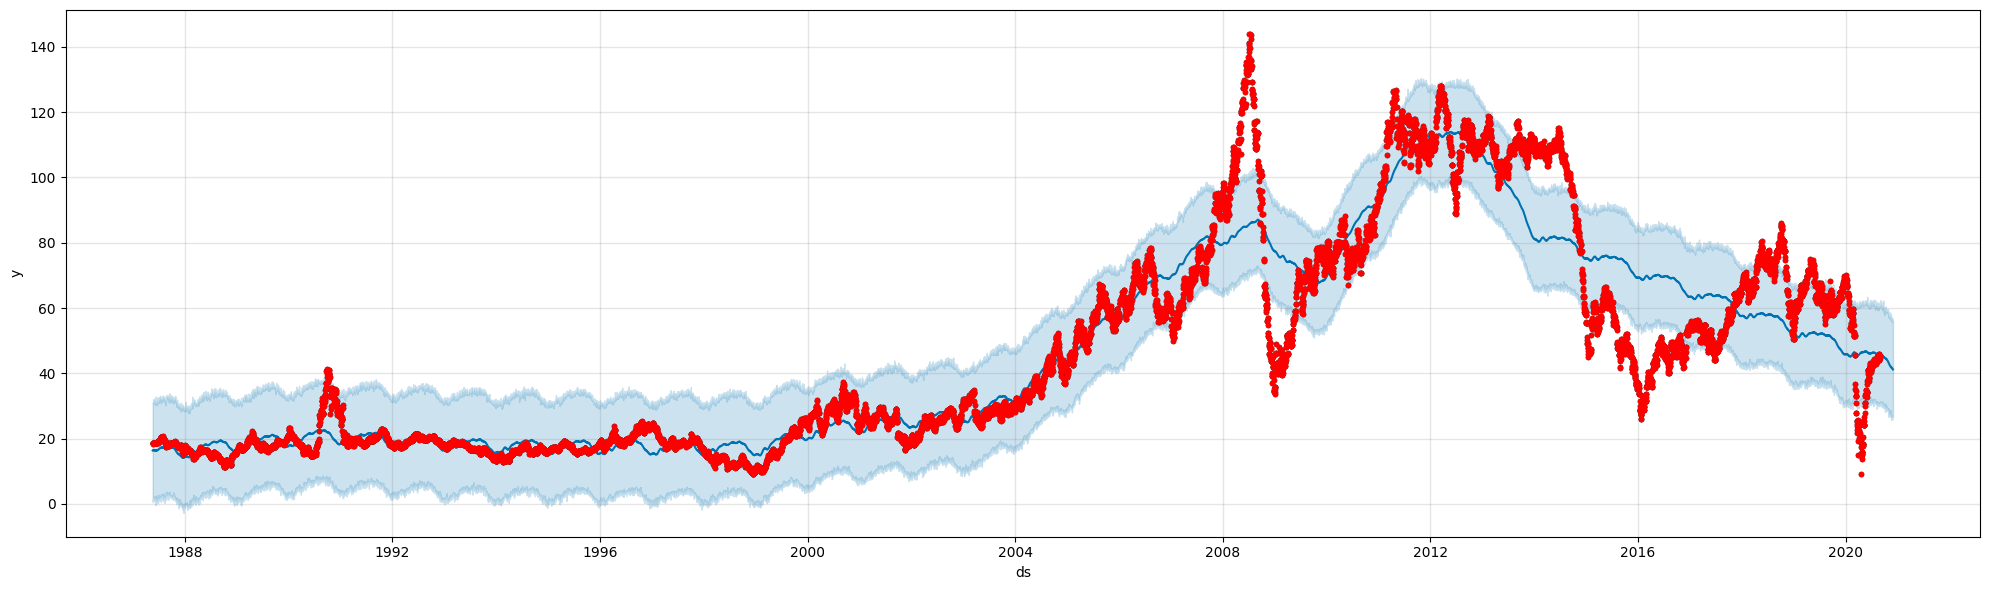

In [42]:
modelo.plot(previsao, figsize=(20,6))
plt.plot(treino['ds'], treino['y'], '.r')

In [43]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = treino[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 17.84%


Percebemos que o nosso MAPE ficou em 17.84%, o que é relativamente alto. Tentaremos utilziar uma abordagem reduzindo a série.

In [44]:
df_prophet_um_ano = df_prophet[-365:]

In [45]:
#Separando em base de treino e teste

split_point = int(len(df_prophet_um_ano) * 0.9)
treino_um_ano = df_prophet_um_ano.iloc[:split_point]
valid_um_ano = df_prophet_um_ano.iloc[split_point:]
print(f'Treino : {treino_um_ano.shape}')
print(f'Valid: {valid_um_ano.shape}')

Treino : (328, 2)
Valid: (37, 2)


In [46]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(treino_um_ano)
dataFramefuture = modelo.make_future_dataframe(periods=7, freq='D')
previsao_um_ano = modelo.predict(dataFramefuture)
previsao_um_ano.head()

17:16:34 - cmdstanpy - INFO - Chain [1] start processing
17:16:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-05-15,75.162003,72.385608,77.449396,75.162003,75.162003,-0.137719,-0.137719,-0.137719,-0.043442,-0.043442,-0.043442,-0.094277,-0.094277,-0.094277,0.0,0.0,0.0,75.024283
1,2023-05-16,75.171072,72.623165,77.651243,75.171072,75.171072,-0.008666,-0.008666,-0.008666,-0.043442,-0.043442,-0.043442,0.034777,0.034777,0.034777,0.0,0.0,0.0,75.162407
2,2023-05-17,75.180142,72.531111,77.471270,75.180142,75.180142,-0.156208,-0.156208,-0.156208,-0.043442,-0.043442,-0.043442,-0.112766,-0.112766,-0.112766,0.0,0.0,0.0,75.023934
3,2023-05-18,75.189211,72.584154,77.523442,75.189211,75.189211,-0.195883,-0.195883,-0.195883,-0.043442,-0.043442,-0.043442,-0.152441,-0.152441,-0.152441,0.0,0.0,0.0,74.993328
4,2023-05-19,75.198280,72.971648,77.903904,75.198280,75.198280,0.179190,0.179190,0.179190,-0.043442,-0.043442,-0.043442,0.222632,0.222632,0.222632,0.0,0.0,0.0,75.377470


c:\Programas Python\Tech Challenge 4\grupo119-dtat-brent-price\data-modelo\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Programas Python\Tech Challenge 4\grupo119-dtat-brent-price\data-modelo\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


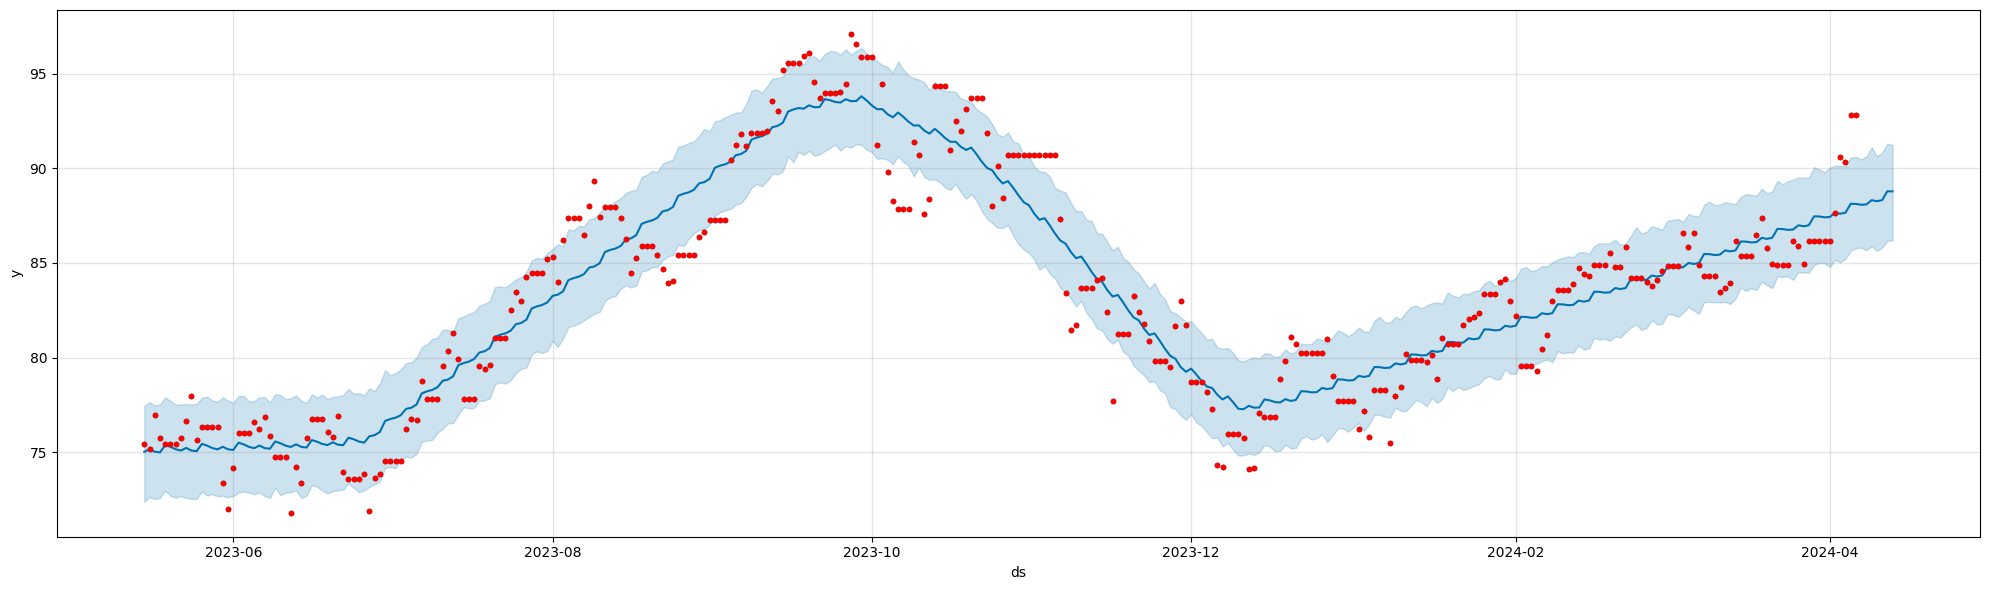

In [47]:
modelo.plot(previsao_um_ano, figsize=(20,6))
plt.plot(treino_um_ano['ds'], treino_um_ano['y'], '.r')

In [48]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao_um_ano[previsao_cols]
valores_reais = treino_um_ano[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao_um_ano, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.94%


Como pode ser visto, dado a comparação dos resultados de MAPE, o modelo utilizando apenas o último ano de dados se comporta melhor do que o modelo utilizando a base inteira.

In [49]:
#Gerando o modelo
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(df_prophet_um_ano)

17:16:38 - cmdstanpy - INFO - Chain [1] start processing
17:16:38 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Salvando o modelo

from joblib import dump

# Salvar o modelo treinado
dump(modelo_prophet, 'modelo_prophet.joblib')

['modelo_prophet.joblib']